<a href="https://colab.research.google.com/github/Zuhair0000/FYP-Research/blob/main/FYP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# List all files in the Colab working directory
print(os.listdir("/content"))

['.config', '风力春季发电.xlsx', '风力秋季发电.xlsx', '光伏冬季发电.xlsx', '风力冬季发电.xlsx', '风力夏季发电.xlsx', '光伏秋季发电.xlsx', '光伏春季发电.xlsx', '光伏夏季发电.xlsx', 'sample_data']


In [2]:
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

all_files = glob.glob("/content/*.xlsx")
print("All Excel files:", all_files)

# Separate solar and wind
solar_files = [f for f in all_files if "光伏" in f]
wind_files  = [f for f in all_files if "风力" in f]

print("Solar files:", solar_files)
print("Wind files:", wind_files)

All Excel files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/光伏冬季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Solar files: ['/content/光伏冬季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Wind files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx']


In [3]:

# Load solar
solar_dfs = [pd.read_excel(f) for f in solar_files]
solar_data = pd.concat(solar_dfs, ignore_index=True)

# Load wind
wind_dfs = [pd.read_excel(f) for f in wind_files]
wind_data = pd.concat(wind_dfs, ignore_index=True)

print("Solar shape:", solar_data.shape)
print("Wind shape:", wind_data.shape)

Solar shape: (8753, 7)
Wind shape: (8752, 5)


In [4]:
print("Solar columns:", solar_data.columns)
print(solar_data.head())

print("\nWind columns:", wind_data.columns)
print(wind_data.head())

print("\nMissing values in Solar:\n", solar_data.isnull().sum())
print("\nMissing values in Wind:\n", wind_data.isnull().sum())

Solar columns: Index(['年份', '时间', '温度', '湿度', '地面辐射强度', '大气上层辐射强度', '光伏发电'], dtype='object')
                   年份  时间      温度     湿度  地面辐射强度  大气上层辐射强度  光伏发电
0 2019-12-01 00:00:00   1 -10.687  0.001     0.0       0.0   0.0
1 2019-12-01 01:00:00   2 -10.623  0.001     0.0       0.0   0.0
2 2019-12-01 02:00:00   3 -10.564  0.001     0.0       0.0   0.0
3 2019-12-01 03:00:00   4 -10.954  0.001     0.0       0.0   0.0
4 2019-12-01 04:00:00   5 -11.344  0.001     0.0       0.0   0.0

Wind columns: Index(['年份', '时间', '空气密度', '风速', '发电功率'], dtype='object')
                   年份  时间   空气密度     风速     发电功率
0 2019-03-01 00:00:00   1  1.282  0.955    0.020
1 2019-03-01 01:00:00   2  1.270  0.881    0.010
2 2019-03-01 02:00:00   3  1.260  1.627    1.825
3 2019-03-01 03:00:00   4  1.253  2.421   26.870
4 2019-03-01 04:00:00   5  1.249  3.450  165.285

Missing values in Solar:
 年份          0
时间          0
温度          0
湿度          0
地面辐射强度      0
大气上层辐射强度    0
光伏发电        0
dtype: int64

Missing val

In [5]:
# --- Solar ---
solar_data = solar_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "温度": "Temperature",
    "湿度": "Humidity",
    "地面辐射强度": "Ground_Irradiance",
    "大气上层辐射强度": "Atmospheric_Irradiance",
    "光伏发电": "Solar_Power"
})

# --- Wind ---
wind_data = wind_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "空气密度": "Air_Density",
    "风速": "Wind_Speed",
    "发电功率": "Wind_Power"
})

In [6]:
solar_data["DateTime"] = pd.to_datetime(solar_data["DateTime"])
wind_data["DateTime"]  = pd.to_datetime(wind_data["DateTime"])

# Sort by datetime
solar_data = solar_data.sort_values("DateTime")
wind_data  = wind_data.sort_values("DateTime")
solar_data


,DateTime,Index,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power
744,2019-01-01 08:00:00,745,-19.889,0.001,82.680,209.252,257.690
745,2019-01-01 09:00:00,746,-19.004,0.001,149.553,345.604,530.391
746,2019-01-01 10:00:00,747,-17.971,0.001,193.625,430.654,871.016
747,2019-01-01 11:00:00,748,-17.281,0.001,203.808,458.550,1087.304
748,2019-01-01 12:00:00,749,-16.738,0.001,185.193,427.391,1010.161
...,...,...,...,...,...,...,...
739,2019-12-31 19:00:00,740,-23.621,0.000,0.000,0.000,0.000
740,2019-12-31 20:00:00,741,-23.980,0.000,0.000,0.000,0.000
741,2019-12-31 21:00:00,742,-24.826,0.000,0.000,0.000,0.000
742,2019-12-31 22:00:00,743,-26.172,0.000,0.000,0.000,0.000


In [7]:
solar_data = solar_data.drop(columns=["Index"])
wind_data  = wind_data.drop(columns=["Index"])

In [8]:
print("Solar date range:", solar_data["DateTime"].min(), "→", solar_data["DateTime"].max())
print("Wind date range:", wind_data["DateTime"].min(), "→", wind_data["DateTime"].max())

print("\nSolar frequency check:")
print(solar_data["DateTime"].diff().value_counts().head())

print("\nWind frequency check:")
print(wind_data["DateTime"].diff().value_counts().head())

Solar date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00
Wind date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00

Solar frequency check:
DateTime
0 days 01:00:00    8751
0 days 00:00:00       1
Name: count, dtype: int64

Wind frequency check:
DateTime
0 days 01:00:00    8751
Name: count, dtype: int64


In [9]:
# Resample Solar
solar_data = solar_data.set_index("DateTime").resample("h").mean().interpolate()

# Resample Wind
wind_data = wind_data.set_index("DateTime").resample("h").mean().interpolate()

# Reset index back
solar_data = solar_data.reset_index()
wind_data  = wind_data.reset_index()

In [10]:
merged_data = pd.merge_asof(
    solar_data.sort_values("DateTime"),
    wind_data.sort_values("DateTime"),
    on="DateTime",
    direction="nearest"  # matches closest timestamp
)
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power
0,2019-01-01 08:00:00,-19.889,0.001,82.680,209.252,257.690,1.335,6.178,1203.800
1,2019-01-01 09:00:00,-19.004,0.001,149.553,345.604,530.391,1.337,6.534,1410.415
2,2019-01-01 10:00:00,-17.971,0.001,193.625,430.654,871.016,1.339,6.747,1547.633
3,2019-01-01 11:00:00,-17.281,0.001,203.808,458.550,1087.304,1.340,6.765,1556.072
4,2019-01-01 12:00:00,-16.738,0.001,185.193,427.391,1010.161,1.342,6.606,1456.741
...,...,...,...,...,...,...,...,...,...
8747,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654
8748,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959
8749,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468
8750,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358


In [11]:
for lag in [1, 3, 6, 24]:  # 1h, 3h, 6h, 24h lags
    merged_data[f"Solar_Power_lag{lag}"] = merged_data["Solar_Power"].shift(lag)
    merged_data[f"Wind_Power_lag{lag}"] = merged_data["Wind_Power"].shift(lag)

In [12]:
merged_data["Solar_Power_roll6h"] = merged_data["Solar_Power"].rolling(window=6).mean()
merged_data["Wind_Power_roll6h"] = merged_data["Wind_Power"].rolling(window=6).mean()

In [13]:
merged_data["hour"] = merged_data["DateTime"].dt.hour
merged_data["dayofweek"] = merged_data["DateTime"].dt.dayofweek
merged_data["month"] = merged_data["DateTime"].dt.month

In [14]:
merged_data = merged_data.dropna().reset_index(drop=True)

In [15]:
train = merged_data[:7000].copy()
val = merged_data[7000:8000].copy()
test = merged_data[8000:].copy()

scaler = MinMaxScaler()
scaled_cols = ["Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
               "Solar_Power", "Air_Density", "Wind_Speed", "Wind_Power"]

scaler.fit(train[scaled_cols])

train[scaled_cols] = scaler.transform(train[scaled_cols])
val[scaled_cols] = scaler.transform(val[scaled_cols])
test[scaled_cols] = scaler.transform(test[scaled_cols])

In [16]:
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power,Solar_Power_lag1,...,Wind_Power_lag3,Solar_Power_lag6,Wind_Power_lag6,Solar_Power_lag24,Wind_Power_lag24,Solar_Power_roll6h,Wind_Power_roll6h,hour,dayofweek,month
0,2019-01-02 08:00:00,-19.250,0.001,106.671,210.916,1492.473,1.337,2.134,12.164,218.077,...,9.707,0.000,49.052,257.690,1203.800,285.091667,14.552000,8,2,1
1,2019-01-02 09:00:00,-17.086,0.001,215.461,347.367,3056.507,1.340,3.019,88.999,1492.473,...,11.803,0.000,28.576,530.391,1410.415,794.509500,24.622500,9,2,1
2,2019-01-02 10:00:00,-15.147,0.001,296.217,432.474,3492.641,1.343,4.137,335.753,3056.507,...,11.997,0.000,13.065,871.016,1547.633,1376.616333,78.403833,10,2,1
3,2019-01-02 11:00:00,-13.838,0.001,322.804,460.390,3499.852,1.345,4.821,562.194,3492.641,...,12.164,0.000,9.707,1087.304,1556.072,1959.925000,170.485000,11,2,1
4,2019-01-02 12:00:00,-13.104,0.001,295.867,429.221,3383.428,1.347,5.215,722.226,3499.852,...,88.999,0.000,11.803,1010.161,1456.741,2523.829667,288.888833,12,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654,0.000,...,1405.135,1409.988,1088.591,0.000,1629.479,173.893667,1264.816167,19,1,12
8724,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959,0.000,...,1444.480,906.648,978.892,0.000,1374.040,22.785667,1267.660667,20,1,12
8725,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468,0.000,...,1386.523,136.714,1119.213,0.000,1468.884,0.000000,1183.536500,21,1,12
8726,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358,0.000,...,1254.654,0.000,1405.135,0.000,1482.002,0.000000,1025.573667,22,1,12


In [17]:
# Save as CSV
merged_data.to_csv("clean_solar_wind.csv", index=False)

# Save as Pickle (keeps data types, useful for reloading later)
merged_data.to_pickle("clean_solar_wind.pkl")

In [18]:
from google.colab import files
files.download("clean_solar_wind.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from google.colab import output
!git config --global user.email "zuhairhassan52@gmail.com"
!git config --global user.name "Zuhair0000"

In [20]:
try:
  merged_data
  print("Using merged_data from environment. Rows:", len(merged_data))
except NameError:
  raise RuntimeError("No 'merged_data' ofund. Load your cleaned CSV first.")

Using merged_data from environment. Rows: 8728


In [21]:
h = 1

df = merged_data.copy().sort_values("DateTime").reset_index(drop=True)

df["Solar_target"] = df["Solar_Power"].shift(-h)
df["Wind_target"] = df["Wind_Power"].shift(-h)

df = df.iloc[:-h].reset_index(drop=True)

print("Data prepared — rows after shifting:", len(df))
print("Example columns:", df.columns.tolist())

Data prepared — rows after shifting: 8727
Example columns: ['DateTime', 'Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Solar_Power', 'Air_Density', 'Wind_Speed', 'Wind_Power', 'Solar_Power_lag1', 'Wind_Power_lag1', 'Solar_Power_lag3', 'Wind_Power_lag3', 'Solar_Power_lag6', 'Wind_Power_lag6', 'Solar_Power_lag24', 'Wind_Power_lag24', 'Solar_Power_roll6h', 'Wind_Power_roll6h', 'hour', 'dayofweek', 'month', 'Solar_target', 'Wind_target']


In [22]:
feature_cols = [
    "Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
    "Air_Density", "Wind_Speed", "Solar_Power_lag1", "Solar_Power_lag24",
    "Wind_Power_lag1", "Wind_Power_lag24", "hour", "dayofweek", "month"
]

feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

X = df[feature_cols].copy()
y_solar = df["Solar_target"].copy()
y_wind = df["Wind_target"].copy()

Using features: ['Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Air_Density', 'Wind_Speed', 'Solar_Power_lag1', 'Solar_Power_lag24', 'Wind_Power_lag1', 'Wind_Power_lag24', 'hour', 'dayofweek', 'month']


In [23]:
# Cell 4: time-based split (70% train, 15% val, 15% test)
n = len(df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X.iloc[:train_end].copy()
X_val   = X.iloc[train_end:val_end].copy()
X_test  = X.iloc[val_end:].copy()

y_train_s = y_solar.iloc[:train_end].copy()
y_val_s   = y_solar.iloc[train_end:val_end].copy()
y_test_s  = y_solar.iloc[val_end:].copy()

print("Sizes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Sizes -> train: (6108, 13) val: (1309, 13) test: (1310, 13)


In [24]:
# ✅ Cell 5: Evaluation utilities + Persistence baseline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- SMAPE function ---
def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# --- General evaluation function ---
def evaluate_metrics(y_true, y_pred):
    """Compute RMSE, MAE, SMAPE, R² for regression forecasts."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

# --- Persistence baseline (1-hour ahead) ---
# Forecast = Solar_Power(t) for predicting Solar_Power(t+1)
if "Solar_Power" in X_test.columns:
    y_pred_persist = X_test["Solar_Power"]
else:
    y_pred_persist = df["Solar_Power"].iloc[val_end:val_end+len(X_test)].reset_index(drop=True)

# Evaluate persistence
persist_scores = evaluate_metrics(y_test_s.values, y_pred_persist.values)
print("Persistence baseline (Solar) ->", persist_scores)

Persistence baseline (Solar) -> {'RMSE': np.float64(398.81572229629853), 'MAE': 184.7564740458015, 'SMAPE(%)': np.float64(35.64301535577778), 'R2': 0.8194389049293163}


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def walk_forward_eval(model, X, y, initial, step):
    """
    Walk-forward validation for time-series forecasting.
    Expands training window step by step and evaluates predictions.

    Parameters:
        model   : sklearn-like estimator
        X, y    : full dataset (features and target)
        initial : size of initial training set
        step    : how many samples to add in each iteration
    """
    preds, actuals = [], []

    for i in range(initial, len(X), step):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test   = X[i:i+step], y[i:i+step]

        if len(X_test) == 0:  # no more test points
            break

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        preds.extend(y_pred)
        actuals.extend(y_test)

    # Convert to arrays
    preds = np.array(preds)
    actuals = np.array(actuals)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    smape_val = smape(actuals, preds)
    r2 = r2_score(actuals, preds)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

In [25]:
# Cell 6: Linear Regression (pipeline with StandardScaler)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import joblib

# Define pipeline: scaling + model
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),     # standardize features
    ("lr", LinearRegression())        # linear regression model
])

# Fit on training data
lr_pipeline.fit(X_train, y_train_s)

# Predict on test
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate using updated SMAPE-based metrics
lr_scores = evaluate_metrics(y_test_s.values, y_pred_lr)
print("Linear Regression ->", lr_scores)

# Save trained model
joblib.dump(lr_pipeline, "lr_pipeline_solar.joblib")

Linear Regression -> {'RMSE': np.float64(570.6679569543222), 'MAE': 407.3402723682594, 'SMAPE(%)': np.float64(150.150823290955), 'R2': 0.6303024152949392}


['lr_pipeline_solar.joblib']

In [26]:
# Cell 7: Random Forest with GridSearchCV (time-series CV)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # respects temporal ordering

# Base RF model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 3]
}

# GridSearch with time-series CV
gsearch = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",  # optimize RMSE
    n_jobs=-1,
    verbose=1
)

# Fit on training set only
gsearch.fit(X_train, y_train_s)

print("Best RF params:", gsearch.best_params_)
best_rf = gsearch.best_estimator_

# Evaluate best RF on test
y_pred_rf = best_rf.predict(X_test)
rf_scores = evaluate_metrics(y_test_s.values, y_pred_rf)
print("Random Forest ->", rf_scores)

# Save best RF
joblib.dump(best_rf, "best_rf_solar.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}
Random Forest -> {'RMSE': np.float64(432.0855920379183), 'MAE': 208.69593886535145, 'SMAPE(%)': np.float64(113.22106954118509), 'R2': 0.7880569362520835}


['best_rf_solar.joblib']

In [37]:
# Walk-forward evaluation for RandomForest
walk_rf = walk_forward_eval(
    RandomForestRegressor(**gsearch.best_params_, random_state=42, n_jobs=-1),
    pd.concat([X_train, X_val, X_test]).reset_index(drop=True),
    pd.concat([y_train_s, y_val_s, y_test_s]).reset_index(drop=True),
    initial=int(0.5 * len(X_train)),  # size of first training window
    step=int(len(X_test) / 5) if len(X_test) >= 5 else 1  # expand window gradually
)

print("Walk-forward metrics for RandomForest:", walk_rf)

Walk-forward metrics for RandomForest: {'RMSE': np.float64(361.2604921539663), 'MAE': 193.48573855543188, 'SMAPE(%)': np.float64(80.13494727423942), 'R2': 0.9165570152440006}


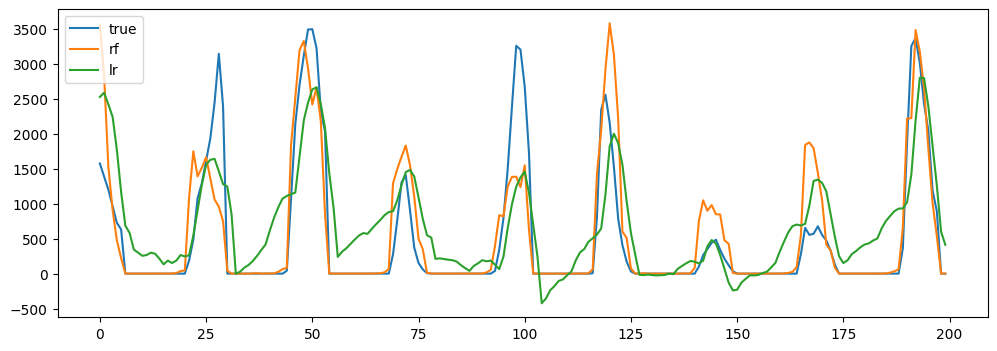

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y_test_s.values[:200], label="true")
plt.plot(y_pred_rf[:200], label="rf")
plt.plot(y_pred_lr[:200], label="lr")
plt.legend()
plt.show()

In [29]:
sorted(zip(feature_cols, best_rf.feature_importances_), key=lambda x: x[1], reverse=True)

[('Ground_Irradiance', np.float64(0.5965764581098184)),
 ('Solar_Power_lag1', np.float64(0.1617507979057815)),
 ('hour', np.float64(0.12387720316893217)),
 ('Solar_Power_lag24', np.float64(0.05154958749418772)),
 ('Atmospheric_Irradiance', np.float64(0.020821122850727448)),
 ('Temperature', np.float64(0.017796413432499148)),
 ('Air_Density', np.float64(0.006743412398669261)),
 ('Wind_Power_lag24', np.float64(0.004969530415703237)),
 ('Wind_Speed', np.float64(0.0040295129322397046)),
 ('Wind_Power_lag1', np.float64(0.0037185043508993175)),
 ('Humidity', np.float64(0.0028258660825086017)),
 ('dayofweek', np.float64(0.0026890090811491473)),
 ('month', np.float64(0.0026525817768844073))]

In [30]:
# Cell: XGBoost Implementation
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid (a small one to start)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train_s)

best_xgb = grid_xgb.best_estimator_
print("Best XGB params:", grid_xgb.best_params_)

# Evaluate on test set
xgb_pred = best_xgb.predict(X_test)
xgb_metrics = evaluate_metrics(y_test_s, xgb_pred)
print("XGBoost ->", xgb_metrics)

# Save model
joblib.dump(best_xgb, "best_xgb_solar.joblib")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost -> {'RMSE': np.float64(418.1856279973868), 'MAE': 247.07919107484435, 'SMAPE(%)': np.float64(148.48930042459125), 'R2': 0.8014737933510269}


['best_xgb_solar.joblib']

In [31]:
# Walk-forward evaluation for XGB
walk_xgb = walk_forward_eval(
    XGBRegressor(**grid_xgb.best_params_, objective="reg:squarederror", random_state=42),
    pd.concat([X_train, X_val, X_test]).reset_index(drop=True),
    pd.concat([y_train_s, y_val_s, y_test_s]).reset_index(drop=True),
    initial=int(0.5 * len(X_train)),  # size of first training window
    step=int(len(X_test) / 5) if len(X_test) >= 5 else 1  # expand window gradually
)

print("Walk-forward metrics for XGB:", walk_xgb)

Walk-forward metrics for XGB: {'RMSE': np.float64(367.8880170888832), 'MAE': 218.64487852814244, 'SMAPE(%)': np.float64(117.10509690702209), 'R2': 0.9134673156591961}


In [32]:
# Collect results into a DataFrame
results = pd.DataFrame([
    {"model": "Persistence", **persist_scores},
    {"model": "LinearRegression", **lr_scores},
    {"model": "RandomForest", **rf_scores},
    {"model": "XGBoost", **xgb_metrics}   # add XGBoost results
])

results

,model,RMSE,MAE,SMAPE(%),R2
0,Persistence,398.815722,184.756474,35.643015,0.819439
1,LinearRegression,570.667957,407.340272,150.150823,0.630302
2,RandomForest,432.085592,208.695939,113.221070,0.788057
3,XGBoost,418.185628,247.079191,148.489300,0.801474


In [38]:
# ---- Walk-forward results collection ----
results_walk = pd.DataFrame([
    {"model": "RandomForest", **walk_rf},
    {"model": "XGBoost", **walk_xgb}
    # Later you can also add walk-forward for LinearRegression or even Persistence if you implement it
])

# Display
print("Walk-forward results:")
results_walk

Walk-forward results:


,model,RMSE,MAE,SMAPE(%),R2
0,RandomForest,361.260492,193.485739,80.134947,0.916557
1,XGBoost,367.888017,218.644879,117.105097,0.913467


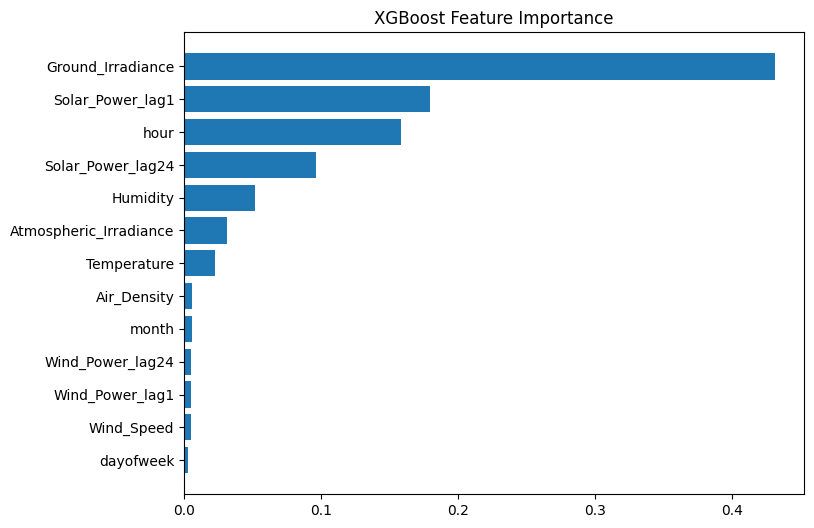

In [35]:
import matplotlib.pyplot as plt

xgb_importances = best_xgb.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()

In [39]:
# Merge static vs walk-forward into one summary
merged_results = results.set_index("model").join(
    results_walk.set_index("model"),
    lsuffix="_static", rsuffix="_walk"
)

merged_results

,RMSE_static,MAE_static,SMAPE(%)_static,R2_static,RMSE_walk,MAE_walk,SMAPE(%)_walk,R2_walk
model,,,,,,,,
Persistence,398.815722,184.756474,35.643015,0.819439,NaN,NaN,NaN,NaN
LinearRegression,570.667957,407.340272,150.150823,0.630302,NaN,NaN,NaN,NaN
RandomForest,432.085592,208.695939,113.221070,0.788057,361.260492,193.485739,80.134947,0.916557
XGBoost,418.185628,247.079191,148.489300,0.801474,367.888017,218.644879,117.105097,0.913467


In [40]:
from sklearn.svm import SVR

# Define pipeline: scaler then SVR
svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),       # 1
    ("svr", SVR())                      # 2
])

# hyperparameter grid to search
svr_param_grid = {
    "svr__kernel": ["rbf", "poly"],     # 3
    "svr__C": [1.0, 10.0, 100.0],       # 4
    "svr__gamma": ["scale", "auto"]     # 5
}

# GridSearchCV with time-series-safe CV (use TimeSeriesSplit if needed)
grid_svr = GridSearchCV(
    estimator=svr_pipeline,             # 6
    param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,                               # small CV for speed; use TimeSeriesSplit if desired
    n_jobs=-1,
    verbose=1
)

# Fit on training data only (like we did before)
grid_svr.fit(X_train, y_train_s)        # 7

# best model and prediction
best_svr = grid_svr.best_estimator_     # 8
y_pred_svr = best_svr.predict(X_test)   # 9

# Evaluate
svr_scores = evaluate_metrics(y_test_s.values, y_pred_svr)
print("SVR ->", svr_scores)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVR -> {'RMSE': np.float64(700.0891315275165), 'MAE': 547.2946022705589, 'SMAPE(%)': np.float64(152.85719275423727), 'R2': 0.443601040447716}


## **Deep Learning**

In [53]:
# CELL 1: imports, basic checks, reproducibility

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Safety: ensure training splits exist; if not, try to rebuild from `merged_data` or `df`
try:
    X_train, X_val, X_test, y_train_s, y_val_s, y_test_s  # just test names exist
    print("Using existing X_train / X_val / X_test and y_train_s / y_val_s / y_test_s")
except NameError:
    # Try to recreate standard time split from `df` or `merged_data`
    if "df" in globals():
        _df = df.copy()
    elif "merged_data" in globals():
        _df = merged_data.copy()
    else:
        raise RuntimeError("No X_train found and no 'df' or 'merged_data' present. Load your cleaned DataFrame first.")
    # assume 'feature_cols' and targets exist
    if "feature_cols" not in globals():
        # choose defaults (adjust if you used different feature names)
        feature_cols = [c for c in _df.columns if c not in ("DateTime", "Solar_target", "Wind_target", "Solar_Power", "Wind_Power")]
    n = len(_df)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)
    X = _df[feature_cols]
    y_solar = _df["Solar_target"]
    X_train = X.iloc[:train_end].copy()
    X_val   = X.iloc[train_end:val_end].copy()
    X_test  = X.iloc[val_end:].copy()
    y_train_s = y_solar.iloc[:train_end].copy()
    y_val_s   = y_solar.iloc[train_end:val_end].copy()
    y_test_s  = y_solar.iloc[val_end:].copy()
    print("Recreated train/val/test splits from dataframe. Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Set seeds for reproducibility (helps but does not guarantee identical DL runs)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Using existing X_train / X_val / X_test and y_train_s / y_val_s / y_test_s


In [54]:
# CELL 2: Fit MinMax scalers for features and target (train-only)
feature_cols = list(X_train.columns)  # explicit list of feature column names

# Feature scaler: fit on X_train only
feature_scaler = MinMaxScaler()
feature_scaler.fit(X_train[feature_cols])

# Target scaler: fit on y_train_s only (reshape to 2D required)
target_scaler = MinMaxScaler()
target_scaler.fit(y_train_s.values.reshape(-1, 1))

# Save scalers so you can reload later
joblib.dump(feature_scaler, "feature_scaler.joblib")
joblib.dump(target_scaler, "target_scaler.joblib")

# Transform train/val/test features and targets
X_train_s = pd.DataFrame(feature_scaler.transform(X_train[feature_cols]), columns=feature_cols, index=X_train.index)
X_val_s   = pd.DataFrame(feature_scaler.transform(X_val[feature_cols]),   columns=feature_cols, index=X_val.index)
X_test_s  = pd.DataFrame(feature_scaler.transform(X_test[feature_cols]),  columns=feature_cols, index=X_test.index)

y_train_s_scaled = target_scaler.transform(y_train_s.values.reshape(-1,1)).flatten()
y_val_s_scaled   = target_scaler.transform(y_val_s.values.reshape(-1,1)).flatten()
y_test_s_scaled  = target_scaler.transform(y_test_s.values.reshape(-1,1)).flatten()

print("Feature scaler fitted. Feature sample (train):")
display(X_train_s.head())

Feature scaler fitted. Feature sample (train):


,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Air_Density,Wind_Speed,Solar_Power_lag1,Solar_Power_lag24,Wind_Power_lag1,Wind_Power_lag24,hour,dayofweek,month
0,0.189456,0.052632,0.118687,0.176241,0.792388,0.104728,0.048462,0.057264,0.002420,0.242870,0.347826,0.333333,0.0
1,0.225571,0.052632,0.239731,0.290260,0.802768,0.153663,0.331661,0.117865,0.002454,0.284555,0.391304,0.333333,0.0
2,0.257932,0.052632,0.329584,0.361375,0.813149,0.215482,0.679224,0.193559,0.017956,0.312240,0.434783,0.333333,0.0
3,0.279778,0.052632,0.359166,0.384702,0.820069,0.253304,0.776142,0.241623,0.067739,0.313942,0.478261,0.333333,0.0
4,0.292028,0.052632,0.329195,0.358657,0.826990,0.275090,0.777745,0.224480,0.113424,0.293902,0.521739,0.333333,0.0


In [55]:
# CELL 3: sequence builder and sequence splits
import numpy as np

def create_sequences(X_df, y_arr, window_size):
    """
    Build sequences for DL:
    - X_df: pandas DataFrame of scaled features ordered by time
    - y_arr: 1D numpy array of scaled target aligned with X_df
    - window_size: number of past steps to include (e.g., 24)
    returns X_seq (n_samples, window_size, n_features), y_seq (n_samples,)
    """
    X = X_df.values
    y = np.array(y_arr)
    n_samples = len(X) - window_size
    Xs, ys = [], []
    for i in range(n_samples):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Build full sequences from concatenated scaled sets
X_full_s = pd.concat([X_train_s, X_val_s, X_test_s]).reset_index(drop=True)
y_full_s = np.concatenate([y_train_s_scaled, y_val_s_scaled, y_test_s_scaled])

window = 24  # lookback window (24 hours)
X_seq_full, y_seq_full = create_sequences(X_full_s, y_full_s, window)

# split back into train/val/test sequences by proportion (consistent with original)
n_total_seq = len(X_seq_full)
train_end_idx = int(0.70 * n_total_seq)
val_end_idx   = int(0.85 * n_total_seq)

X_train_seq = X_seq_full[:train_end_idx]
X_val_seq   = X_seq_full[train_end_idx:val_end_idx]
X_test_seq  = X_seq_full[val_end_idx:]

y_train_seq = y_seq_full[:train_end_idx]
y_val_seq   = y_seq_full[train_end_idx:val_end_idx]
y_test_seq  = y_seq_full[val_end_idx:]

print("Sequence shapes -> X_train_seq:", X_train_seq.shape, "X_val_seq:", X_val_seq.shape, "X_test_seq:", X_test_seq.shape)

Sequence shapes -> X_train_seq: (6092, 24, 13) X_val_seq: (1305, 24, 13) X_test_seq: (1306, 24, 13)


In [42]:
# Suppose we built X_seq, y_seq from full data. Now compute split sizes (same time proportions)
n_total = len(X_seq)
train_end_idx = int(0.70 * n_total)
val_end_idx = int(0.85 * n_total)

X_train_seq = X_seq[:train_end_idx]
X_val_seq = X_seq[train_end_idx:val_end_idx]
X_test_seq = X_seq[val_end_idx:]

y_train_seq = y_seq[:train_end_idx]
y_val_seq = y_seq[train_end_idx:val_end_idx]
y_test_seq = y_seq[val_end_idx:]

In [56]:
# CELL 5: LSTM model training + evaluation (end-to-end)

# model definition
n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

model_lstm = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# callbacks: early stop + save best (Keras native format .keras avoids HDF5 warning)
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_loss")

# Train
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es, ckpt],
    verbose=2
)

# Load best model (optional but safe)
model_lstm = tf.keras.models.load_model("best_lstm_model.keras")

# Predict (scaled), inverse-transform to original units
y_pred_scaled = model_lstm.predict(X_test_seq).flatten()
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

# Evaluate in original units
lstm_scores = evaluate_metrics(y_true, y_pred)
print("LSTM ->", lstm_scores)

# Save model explicitly
model_lstm.save("final_lstm_model.keras")

Epoch 1/50
191/191 - 5s - 25ms/step - loss: 0.0351 - mae: 0.1364 - val_loss: 0.0224 - val_mae: 0.1055
Epoch 2/50
191/191 - 2s - 12ms/step - loss: 0.0196 - mae: 0.0947 - val_loss: 0.0221 - val_mae: 0.1062
Epoch 3/50
191/191 - 2s - 12ms/step - loss: 0.0164 - mae: 0.0840 - val_loss: 0.0215 - val_mae: 0.1009
Epoch 4/50
191/191 - 3s - 17ms/step - loss: 0.0151 - mae: 0.0793 - val_loss: 0.0230 - val_mae: 0.1046
Epoch 5/50
191/191 - 4s - 23ms/step - loss: 0.0145 - mae: 0.0766 - val_loss: 0.0203 - val_mae: 0.0957
Epoch 6/50
191/191 - 3s - 14ms/step - loss: 0.0136 - mae: 0.0738 - val_loss: 0.0218 - val_mae: 0.1002
Epoch 7/50
191/191 - 3s - 14ms/step - loss: 0.0130 - mae: 0.0717 - val_loss: 0.0214 - val_mae: 0.0999
Epoch 8/50
191/191 - 3s - 16ms/step - loss: 0.0125 - mae: 0.0698 - val_loss: 0.0207 - val_mae: 0.0975
Epoch 9/50
191/191 - 2s - 12ms/step - loss: 0.0123 - mae: 0.0691 - val_loss: 0.0202 - val_mae: 0.0966
Epoch 10/50
191/191 - 2s - 13ms/step - loss: 0.0120 - mae: 0.0673 - val_loss: 0.02

In [57]:
# CELL 6: GRU training + eval (same pipeline as LSTM)
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])

es_gru = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt_gru = ModelCheckpoint("best_gru_model.keras", save_best_only=True, monitor="val_loss")

history_gru = model_gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es_gru, ckpt_gru],
    verbose=2
)

model_gru = tf.keras.models.load_model("best_gru_model.keras")

y_pred_scaled_gru = model_gru.predict(X_test_seq).flatten()
y_pred_gru = target_scaler.inverse_transform(y_pred_scaled_gru.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

gru_scores = evaluate_metrics(y_true, y_pred_gru)
print("GRU ->", gru_scores)
model_gru.save("final_gru_model.keras")

Epoch 1/50
191/191 - 9s - 45ms/step - loss: 0.0410 - mae: 0.1430 - val_loss: 0.0279 - val_mae: 0.1126
Epoch 2/50
191/191 - 3s - 14ms/step - loss: 0.0203 - mae: 0.0931 - val_loss: 0.0263 - val_mae: 0.1006
Epoch 3/50
191/191 - 3s - 14ms/step - loss: 0.0166 - mae: 0.0809 - val_loss: 0.0248 - val_mae: 0.0992
Epoch 4/50
191/191 - 3s - 17ms/step - loss: 0.0150 - mae: 0.0751 - val_loss: 0.0276 - val_mae: 0.1034
Epoch 5/50
191/191 - 3s - 15ms/step - loss: 0.0141 - mae: 0.0721 - val_loss: 0.0289 - val_mae: 0.1094
Epoch 6/50
191/191 - 3s - 14ms/step - loss: 0.0133 - mae: 0.0696 - val_loss: 0.0296 - val_mae: 0.1081
Epoch 7/50
191/191 - 3s - 13ms/step - loss: 0.0130 - mae: 0.0688 - val_loss: 0.0263 - val_mae: 0.1060
Epoch 8/50
191/191 - 6s - 32ms/step - loss: 0.0127 - mae: 0.0679 - val_loss: 0.0298 - val_mae: 0.1060
Epoch 9/50
191/191 - 4s - 21ms/step - loss: 0.0119 - mae: 0.0663 - val_loss: 0.0300 - val_mae: 0.1100
Epoch 10/50
191/191 - 3s - 14ms/step - loss: 0.0118 - mae: 0.0649 - val_loss: 0.02

In [58]:
# CELL 7: Bidirectional LSTM training + eval
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_bilstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

es_bi = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt_bi = ModelCheckpoint("best_bilstm_model.keras", save_best_only=True, monitor="val_loss")

history_bi = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es_bi, ckpt_bi],
    verbose=2
)

model_bilstm = tf.keras.models.load_model("best_bilstm_model.keras")

y_pred_scaled_bi = model_bilstm.predict(X_test_seq).flatten()
y_pred_bi = target_scaler.inverse_transform(y_pred_scaled_bi.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

bilstm_scores = evaluate_metrics(y_true, y_pred_bi)
print("Bi-LSTM ->", bilstm_scores)
model_bilstm.save("final_bilstm_model.keras")

Epoch 1/50
191/191 - 11s - 55ms/step - loss: 0.0286 - mae: 0.1187 - val_loss: 0.0223 - val_mae: 0.1036
Epoch 2/50
191/191 - 4s - 23ms/step - loss: 0.0193 - mae: 0.0924 - val_loss: 0.0200 - val_mae: 0.0946
Epoch 3/50
191/191 - 4s - 20ms/step - loss: 0.0167 - mae: 0.0846 - val_loss: 0.0174 - val_mae: 0.0879
Epoch 4/50
191/191 - 5s - 25ms/step - loss: 0.0153 - mae: 0.0798 - val_loss: 0.0170 - val_mae: 0.0840
Epoch 5/50
191/191 - 5s - 24ms/step - loss: 0.0141 - mae: 0.0761 - val_loss: 0.0181 - val_mae: 0.0860
Epoch 6/50
191/191 - 4s - 21ms/step - loss: 0.0134 - mae: 0.0725 - val_loss: 0.0172 - val_mae: 0.0820
Epoch 7/50
191/191 - 4s - 19ms/step - loss: 0.0128 - mae: 0.0710 - val_loss: 0.0169 - val_mae: 0.0822
Epoch 8/50
191/191 - 4s - 22ms/step - loss: 0.0123 - mae: 0.0684 - val_loss: 0.0184 - val_mae: 0.0859
Epoch 9/50
191/191 - 5s - 28ms/step - loss: 0.0120 - mae: 0.0677 - val_loss: 0.0183 - val_mae: 0.0860
Epoch 10/50
191/191 - 10s - 50ms/step - loss: 0.0115 - mae: 0.0658 - val_loss: 0.

,model,RMSE,MAE,SMAPE(%),R2
0,LSTM,983.640605,567.835265,154.154131,-0.097592
1,GRU,1309.861091,843.760656,159.786120,-0.946339
2,BiLSTM,951.527119,715.798078,158.495871,-0.027094


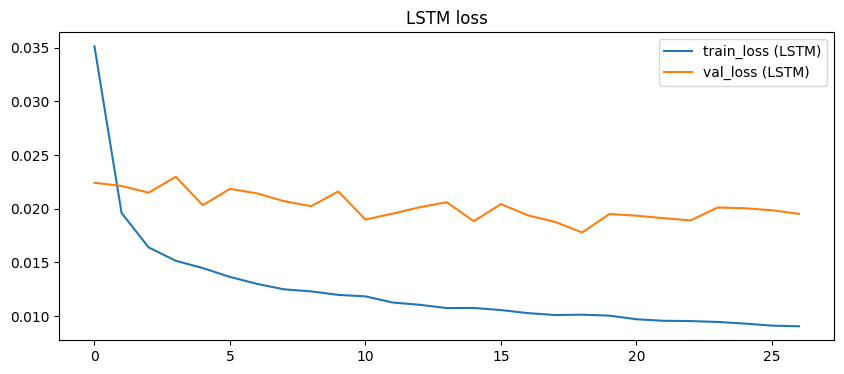

In [59]:
# CELL 8: Compare static metrics from DL models
results_dl = pd.DataFrame([
    {"model": "LSTM", "RMSE": lstm_scores["RMSE"], "MAE": lstm_scores["MAE"], "SMAPE(%)": lstm_scores["SMAPE(%)"], "R2": lstm_scores["R2"]},
    {"model": "GRU", "RMSE": gru_scores["RMSE"],  "MAE": gru_scores["MAE"],  "SMAPE(%)": gru_scores["SMAPE(%)"],  "R2": gru_scores["R2"]},
    {"model": "BiLSTM", "RMSE": bilstm_scores["RMSE"], "MAE": bilstm_scores["MAE"], "SMAPE(%)": bilstm_scores["SMAPE(%)"], "R2": bilstm_scores["R2"]}
])
display(results_dl)

# Plot training histories (example LSTM)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(history_lstm.history["loss"], label="train_loss (LSTM)")
plt.plot(history_lstm.history["val_loss"], label="val_loss (LSTM)")
plt.legend()
plt.title("LSTM loss")
plt.show()

In [60]:
import optuna

In [61]:
# CELL 2: Objective function for XGBoost
def objective_xgb(trial):
    # Search space
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 400]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
    }

    tscv = TimeSeriesSplit(n_splits=3)  # 3 folds for speed
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_ = y_train_s.iloc[train_idx], y_train_s.iloc[val_idx]

        model = XGBRegressor(objective="reg:squarederror", random_state=42, **params)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val_)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_, preds)))

    return np.mean(rmse_scores)  # Optuna minimizes this


# CELL 3: Run Optuna for XGB
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=30)  # 30 trials (increase for more thorough search)

print("Best params (XGB):", study_xgb.best_params)
print("Best RMSE:", study_xgb.best_value)

# Train final best model
best_xgb = XGBRegressor(objective="reg:squarederror", random_state=42, **study_xgb.best_params)
best_xgb.fit(X_train, y_train_s)

# Evaluate on test
y_pred_xgb_opt = best_xgb.predict(X_test)
xgb_opt_scores = evaluate_metrics(y_test_s, y_pred_xgb_opt)
print("Optuna-tuned XGB ->", xgb_opt_scores)

[I 2025-09-14 07:06:24,781] A new study created in memory with name: no-name-87f0f83b-ae5f-4e60-92e7-f4c7b976dafa
[I 2025-09-14 07:06:26,471] Trial 0 finished with value: 460.6357214939531 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.02593010697023586, 'subsample': 0.7566860723390507, 'colsample_bytree': 0.8664887410905977}. Best is trial 0 with value: 460.6357214939531.
[I 2025-09-14 07:06:28,998] Trial 1 finished with value: 548.5382911101213 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.17807402827302757, 'subsample': 0.8821613500385914, 'colsample_bytree': 0.667011201690796}. Best is trial 0 with value: 460.6357214939531.
[I 2025-09-14 07:06:30,285] Trial 2 finished with value: 526.3263952648562 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.171080098504329, 'subsample': 0.7184748384982481, 'colsample_bytree': 0.6809561833899775}. Best is trial 0 with value: 460.6357214939531.
[I 2025-09-14 07:06:31,6

Best params (XGB): {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.04576073681251359, 'subsample': 0.8997283156569267, 'colsample_bytree': 0.9865015451906601}
Best RMSE: 422.61673645467795
Optuna-tuned XGB -> {'RMSE': np.float64(386.21730832515567), 'MAE': 220.6764393753889, 'SMAPE(%)': np.float64(146.28985710228145), 'R2': 0.8306664147373535}


In [62]:
# CELL 4: Objective for RandomForest
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 400]),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_ = y_train_s.iloc[train_idx], y_train_s.iloc[val_idx]

        model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val_)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_, preds)))

    return np.mean(rmse_scores)

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=30)

print("Best params (RF):", study_rf.best_params)
print("Best RMSE:", study_rf.best_value)

# Train and evaluate best RF
best_rf_opt = RandomForestRegressor(random_state=42, n_jobs=-1, **study_rf.best_params)
best_rf_opt.fit(X_train, y_train_s)
y_pred_rf_opt = best_rf_opt.predict(X_test)
rf_opt_scores = evaluate_metrics(y_test_s, y_pred_rf_opt)
print("Optuna-tuned RF ->", rf_opt_scores)

[I 2025-09-14 07:09:57,694] A new study created in memory with name: no-name-11b8a284-a206-40c0-8833-63cb5d639fc5
[I 2025-09-14 07:10:04,813] Trial 0 finished with value: 425.63873318013526 and parameters: {'n_estimators': 100, 'max_depth': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 425.63873318013526.
[I 2025-09-14 07:10:21,282] Trial 1 finished with value: 434.50222942468264 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_leaf': 3}. Best is trial 0 with value: 425.63873318013526.
[I 2025-09-14 07:10:27,054] Trial 2 finished with value: 418.7268179064201 and parameters: {'n_estimators': 100, 'max_depth': 11, 'min_samples_leaf': 5}. Best is trial 2 with value: 418.7268179064201.
[I 2025-09-14 07:10:38,674] Trial 3 finished with value: 424.7094438493154 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 1}. Best is trial 2 with value: 418.7268179064201.
[I 2025-09-14 07:10:44,697] Trial 4 finished with value: 453.3110301098186 and p

Best params (RF): {'n_estimators': 400, 'max_depth': 15, 'min_samples_leaf': 4}
Best RMSE: 414.8095956376895
Optuna-tuned RF -> {'RMSE': np.float64(426.7470190015472), 'MAE': 205.1634399397999, 'SMAPE(%)': np.float64(141.71899365999582), 'R2': 0.7932618478007609}


In [64]:
def objective_lstm(trial):
    """
    Optuna objective for tuning LSTM hyperparameters.
    Builds, trains, and evaluates a small LSTM.
    """
    # --- Hyperparameters to tune ---
    n_units = trial.suggest_int("units", 32, 128, step=32)    # number of LSTM units
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)      # dropout %
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16) # dense layer size
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)           # learning rate
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30   # keep short for Optuna speed (final model can train longer)

    # --- Build model ---
    model = Sequential([
        LSTM(n_units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    # --- Early stopping ---
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # --- Train ---
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # --- Evaluate on validation ---
    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]  # return MSE
    return val_loss

study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(objective_lstm, n_trials=10)   # try 10 trials first

print("Best LSTM params:", study_lstm.best_params)

[I 2025-09-14 07:20:08,768] A new study created in memory with name: no-name-5360d075-56fa-45f1-ab3a-05d48b8ff5bf
[I 2025-09-14 07:22:05,451] Trial 0 finished with value: 0.01756623201072216 and parameters: {'units': 96, 'dropout': 0.26633266214899864, 'dense_units': 48, 'lr': 0.00046055637310817314, 'batch_size': 16}. Best is trial 0 with value: 0.01756623201072216.
[I 2025-09-14 07:22:44,713] Trial 1 finished with value: 0.019683396443724632 and parameters: {'units': 64, 'dropout': 0.18191035599239083, 'dense_units': 48, 'lr': 0.006502313468218208, 'batch_size': 16}. Best is trial 0 with value: 0.01756623201072216.
[I 2025-09-14 07:23:19,717] Trial 2 finished with value: 0.017487308010458946 and parameters: {'units': 64, 'dropout': 0.22580048693274624, 'dense_units': 64, 'lr': 0.004615875892661756, 'batch_size': 16}. Best is trial 2 with value: 0.017487308010458946.
[I 2025-09-14 07:24:43,375] Trial 3 finished with value: 0.01714227721095085 and parameters: {'units': 128, 'dropout': 

Best LSTM params: {'units': 96, 'dropout': 0.2305304475374962, 'dense_units': 32, 'lr': 0.0048073548702246465, 'batch_size': 32}


In [65]:
best_params = study_lstm.best_params

model_lstm = Sequential([
    LSTM(best_params["units"], input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params["dropout"]),
    Dense(best_params["dense_units"], activation="relu"),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["lr"])
model_lstm.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,   # longer training for final model
    batch_size=best_params["batch_size"],
    callbacks=[es],
    verbose=2
)

# Predictions
y_pred_lstm = model_lstm.predict(X_test_seq).flatten()

# Evaluate with your custom metrics
lstm_scores = evaluate_metrics(y_test_seq, y_pred_lstm)
print("LSTM (Optuna best) ->", lstm_scores)

Epoch 1/100
191/191 - 7s - 38ms/step - loss: 0.0311 - mae: 0.1180 - val_loss: 0.0195 - val_mae: 0.0934
Epoch 2/100
191/191 - 4s - 20ms/step - loss: 0.0168 - mae: 0.0821 - val_loss: 0.0215 - val_mae: 0.0985
Epoch 3/100
191/191 - 3s - 15ms/step - loss: 0.0147 - mae: 0.0759 - val_loss: 0.0182 - val_mae: 0.0859
Epoch 4/100
191/191 - 3s - 16ms/step - loss: 0.0142 - mae: 0.0745 - val_loss: 0.0175 - val_mae: 0.0828
Epoch 5/100
191/191 - 4s - 19ms/step - loss: 0.0135 - mae: 0.0719 - val_loss: 0.0174 - val_mae: 0.0844
Epoch 6/100
191/191 - 3s - 15ms/step - loss: 0.0130 - mae: 0.0703 - val_loss: 0.0159 - val_mae: 0.0787
Epoch 7/100
191/191 - 3s - 15ms/step - loss: 0.0125 - mae: 0.0684 - val_loss: 0.0186 - val_mae: 0.0859
Epoch 8/100
191/191 - 3s - 15ms/step - loss: 0.0122 - mae: 0.0686 - val_loss: 0.0192 - val_mae: 0.0868
Epoch 9/100
191/191 - 5s - 27ms/step - loss: 0.0119 - mae: 0.0671 - val_loss: 0.0220 - val_mae: 0.0897
Epoch 10/100
191/191 - 3s - 15ms/step - loss: 0.0113 - mae: 0.0650 - val_

In [66]:
def objective_gru(trial):
    n_units = trial.suggest_int("units", 32, 128, step=32)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30

    model = Sequential([
        GRU(n_units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]
    return val_loss

study_gru = optuna.create_study(direction="minimize")
study_gru.optimize(objective_gru, n_trials=10)

print("Best GRU params:", study_gru.best_params)

[I 2025-09-14 07:35:28,143] A new study created in memory with name: no-name-e7d4bf0a-cd36-4541-917b-38c87f68f117
[I 2025-09-14 07:36:03,495] Trial 0 finished with value: 0.025030339136719704 and parameters: {'units': 96, 'dropout': 0.12123687928269122, 'dense_units': 64, 'lr': 0.002674590729564721, 'batch_size': 64}. Best is trial 0 with value: 0.025030339136719704.
[I 2025-09-14 07:36:37,679] Trial 1 finished with value: 0.021582674235105515 and parameters: {'units': 96, 'dropout': 0.44424864897359695, 'dense_units': 64, 'lr': 0.0006023880722244796, 'batch_size': 64}. Best is trial 1 with value: 0.021582674235105515.
[I 2025-09-14 07:38:20,511] Trial 2 finished with value: 0.014017479494214058 and parameters: {'units': 96, 'dropout': 0.27865749016023084, 'dense_units': 48, 'lr': 0.0033260078080656766, 'batch_size': 16}. Best is trial 2 with value: 0.014017479494214058.
[I 2025-09-14 07:40:10,207] Trial 3 finished with value: 0.021531466394662857 and parameters: {'units': 64, 'dropout

Best GRU params: {'units': 96, 'dropout': 0.27865749016023084, 'dense_units': 48, 'lr': 0.0033260078080656766, 'batch_size': 16}


In [68]:
from tensorflow.keras.layers import Bidirectional

def objective_bilstm(trial):
    """
    Optuna objective for tuning Bidirectional LSTM.
    """
    # --- Hyperparameters to tune ---
    n_units = trial.suggest_int("units", 32, 128, step=32)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30   # shorter for Optuna, longer later

    # --- Build model ---
    model = Sequential([
        Bidirectional(LSTM(n_units), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # --- Train ---
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # --- Evaluate on validation ---
    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]
    return val_loss

study_bilstm = optuna.create_study(direction="minimize")
study_bilstm.optimize(objective_bilstm, n_trials=10)   # start with 10 trials

print("Best BiLSTM params:", study_bilstm.best_params)

[I 2025-09-14 07:47:50,954] A new study created in memory with name: no-name-669846c6-7d70-47fe-8a34-34d238037d0c
[I 2025-09-14 07:49:26,628] Trial 0 finished with value: 0.012276974506676197 and parameters: {'units': 64, 'dropout': 0.30478291472563146, 'dense_units': 48, 'lr': 0.0066972069679708075, 'batch_size': 16}. Best is trial 0 with value: 0.012276974506676197.
[I 2025-09-14 07:51:39,293] Trial 1 finished with value: 0.017391398549079895 and parameters: {'units': 32, 'dropout': 0.1628738819580095, 'dense_units': 48, 'lr': 0.0001074992591165421, 'batch_size': 32}. Best is trial 0 with value: 0.012276974506676197.
[I 2025-09-14 07:52:33,311] Trial 2 finished with value: 0.017864828929305077 and parameters: {'units': 64, 'dropout': 0.41366585487197327, 'dense_units': 16, 'lr': 0.000512845125455929, 'batch_size': 64}. Best is trial 0 with value: 0.012276974506676197.
[I 2025-09-14 07:54:31,706] Trial 3 finished with value: 0.014489912427961826 and parameters: {'units': 64, 'dropout'

Best BiLSTM params: {'units': 128, 'dropout': 0.37952577774743146, 'dense_units': 48, 'lr': 0.002132086796035184, 'batch_size': 16}


In [69]:
best_params_bilstm = study_bilstm.best_params

model_bilstm = Sequential([
    Bidirectional(LSTM(best_params_bilstm["units"]), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params_bilstm["dropout"]),
    Dense(best_params_bilstm["dense_units"], activation="relu"),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params_bilstm["lr"])
model_bilstm.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,   # longer final training
    batch_size=best_params_bilstm["batch_size"],
    callbacks=[es],
    verbose=2
)

# Predictions
y_pred_bilstm = model_bilstm.predict(X_test_seq).flatten()

# Evaluate
bilstm_scores = evaluate_metrics(y_test_seq, y_pred_bilstm)
print("BiLSTM (Optuna best) ->", bilstm_scores)

Epoch 1/100
381/381 - 18s - 48ms/step - loss: 0.0250 - mae: 0.1059 - val_loss: 0.0188 - val_mae: 0.0898
Epoch 2/100
381/381 - 12s - 31ms/step - loss: 0.0170 - mae: 0.0819 - val_loss: 0.0182 - val_mae: 0.0835
Epoch 3/100
381/381 - 22s - 57ms/step - loss: 0.0150 - mae: 0.0743 - val_loss: 0.0153 - val_mae: 0.0778
Epoch 4/100
381/381 - 20s - 52ms/step - loss: 0.0140 - mae: 0.0717 - val_loss: 0.0148 - val_mae: 0.0763
Epoch 5/100
381/381 - 20s - 52ms/step - loss: 0.0132 - mae: 0.0691 - val_loss: 0.0143 - val_mae: 0.0744
Epoch 6/100
381/381 - 21s - 56ms/step - loss: 0.0126 - mae: 0.0680 - val_loss: 0.0136 - val_mae: 0.0718
Epoch 7/100
381/381 - 12s - 32ms/step - loss: 0.0121 - mae: 0.0666 - val_loss: 0.0146 - val_mae: 0.0755
Epoch 8/100
381/381 - 13s - 34ms/step - loss: 0.0116 - mae: 0.0650 - val_loss: 0.0142 - val_mae: 0.0747
Epoch 9/100
381/381 - 12s - 31ms/step - loss: 0.0111 - mae: 0.0635 - val_loss: 0.0138 - val_mae: 0.0746
Epoch 10/100
381/381 - 21s - 55ms/step - loss: 0.0110 - mae: 0.0

## **ML for Wind**

In [71]:
# Wind targets
y_train_w = y_wind.iloc[:train_end].copy()
y_val_w   = y_wind.iloc[train_end:val_end].copy()
y_test_w  = y_wind.iloc[val_end:].copy()

# Persistence: next step ≈ last observed Wind_Power
if "Wind_Power" in X_test.columns:
    y_pred_persist_w = X_test["Wind_Power"]
else:
    y_pred_persist_w = df["Wind_Power"].iloc[val_end:val_end+len(X_test)].reset_index(drop=True)

persist_scores_w = evaluate_metrics(y_test_w.values, y_pred_persist_w.values)
print("Persistence baseline (Wind) ->", persist_scores_w)

Persistence baseline (Wind) -> {'RMSE': np.float64(247.8914322335116), 'MAE': 162.91976030534352, 'SMAPE(%)': np.float64(26.24444663165979), 'R2': 0.9459897333244991}


In [72]:
lr_pipeline_w = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

lr_pipeline_w.fit(X_train, y_train_w)
y_pred_lr_w = lr_pipeline_w.predict(X_test)

lr_scores_w = evaluate_metrics(y_test_w.values, y_pred_lr_w)
print("Linear Regression (Wind) ->", lr_scores_w)

Linear Regression (Wind) -> {'RMSE': np.float64(366.27034486835595), 'MAE': 269.5837639271422, 'SMAPE(%)': np.float64(50.81280530319431), 'R2': 0.8820883265817653}


In [73]:
gsearch_rf_w = GridSearchCV(
    estimator=rf,   # same rf object you defined before
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gsearch_rf_w.fit(X_train, y_train_w)
best_rf_w = gsearch_rf_w.best_estimator_

y_pred_rf_w = best_rf_w.predict(X_test)
rf_scores_w = evaluate_metrics(y_test_w.values, y_pred_rf_w)
print("Random Forest (Wind) ->", rf_scores_w)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest (Wind) -> {'RMSE': np.float64(189.94988267177078), 'MAE': 126.59732881814361, 'SMAPE(%)': np.float64(23.5102521165805), 'R2': 0.9682874366709875}


In [74]:
grid_xgb_w = GridSearchCV(
    estimator=xgb_model,     # same base XGBRegressor you used before
    param_grid=xgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb_w.fit(X_train, y_train_w)
best_xgb_w = grid_xgb_w.best_estimator_

y_pred_xgb_w = best_xgb_w.predict(X_test)
xgb_scores_w = evaluate_metrics(y_test_w.values, y_pred_xgb_w)
print("XGBoost (Wind) ->", xgb_scores_w)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
XGBoost (Wind) -> {'RMSE': np.float64(196.86440677366127), 'MAE': 135.7550660370823, 'SMAPE(%)': np.float64(27.26391040017477), 'R2': 0.9659366236252531}


In [75]:
results_wind_ml = pd.DataFrame([
    {"model": "Persistence", **persist_scores_w},
    {"model": "LinearRegression", **lr_scores_w},
    {"model": "RandomForest", **rf_scores_w},
    {"model": "XGBoost", **xgb_scores_w}
])

print("Wind ML Results:")
display(results_wind_ml)

Wind ML Results:


,model,RMSE,MAE,SMAPE(%),R2
0,Persistence,247.891432,162.919760,26.244447,0.945990
1,LinearRegression,366.270345,269.583764,50.812805,0.882088
2,RandomForest,189.949883,126.597329,23.510252,0.968287
3,XGBoost,196.864407,135.755066,27.263910,0.965937


## **DL for Wind**

In [76]:
from sklearn.preprocessing import MinMaxScaler

# Features (same across solar & wind)
feature_cols = X_train.columns.tolist()

# Scale features
feature_scaler_w = MinMaxScaler()
feature_scaler_w.fit(X_train[feature_cols])

X_train_w_s = pd.DataFrame(feature_scaler_w.transform(X_train[feature_cols]),
                           columns=feature_cols, index=X_train.index)
X_val_w_s   = pd.DataFrame(feature_scaler_w.transform(X_val[feature_cols]),
                           columns=feature_cols, index=X_val.index)
X_test_w_s  = pd.DataFrame(feature_scaler_w.transform(X_test[feature_cols]),
                           columns=feature_cols, index=X_test.index)

# Scale Wind target
target_scaler_w = MinMaxScaler()
target_scaler_w.fit(y_train_w.values.reshape(-1,1))

y_train_w_s = target_scaler_w.transform(y_train_w.values.reshape(-1,1)).flatten()
y_val_w_s   = target_scaler_w.transform(y_val_w.values.reshape(-1,1)).flatten()
y_test_w_s  = target_scaler_w.transform(y_test_w.values.reshape(-1,1)).flatten()

In [77]:
def create_sequences(X_df, y_arr, window_size):
    X = X_df.values
    y = np.array(y_arr)
    n_samples = len(X) - window_size
    Xs, ys = [], []
    for i in range(n_samples):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Concatenate train+val+test for sliding windows
X_full_w = pd.concat([X_train_w_s, X_val_w_s, X_test_w_s]).reset_index(drop=True)
y_full_w = np.concatenate([y_train_w_s, y_val_w_s, y_test_w_s])

# Window length = 24 hours (can tune)
window = 24
X_seq_w, y_seq_w = create_sequences(X_full_w, y_full_w, window)

# Train/val/test splits
n_total_w = len(X_seq_w)
train_end_idx_w = int(0.70 * n_total_w)
val_end_idx_w   = int(0.85 * n_total_w)

X_train_w_seq = X_seq_w[:train_end_idx_w]
X_val_w_seq   = X_seq_w[train_end_idx_w:val_end_idx_w]
X_test_w_seq  = X_seq_w[val_end_idx_w:]

y_train_w_seq = y_seq_w[:train_end_idx_w]
y_val_w_seq   = y_seq_w[train_end_idx_w:val_end_idx_w]
y_test_w_seq  = y_seq_w[val_end_idx_w:]

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

n_timesteps = X_train_w_seq.shape[1]
n_features  = X_train_w_seq.shape[2]

# LSTM
lstm_w = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

lstm_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt = ModelCheckpoint("best_lstm_wind.keras", save_best_only=True, monitor="val_loss")

history_lstm_w = lstm_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt],
    verbose=2
)

# Predictions (inverse transform to original scale)
y_pred_lstm_w = lstm_w.predict(X_test_w_seq).flatten()
y_pred_lstm_w_rescaled = target_scaler_w.inverse_transform(y_pred_lstm_w.reshape(-1,1)).flatten()
y_test_w_rescaled = target_scaler_w.inverse_transform(y_test_w_seq.reshape(-1,1)).flatten()

lstm_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_lstm_w_rescaled)
print("LSTM (Wind) ->", lstm_w_scores)

Epoch 1/100
191/191 - 7s - 36ms/step - loss: 0.0381 - mae: 0.1510 - val_loss: 0.0324 - val_mae: 0.1383
Epoch 2/100
191/191 - 4s - 21ms/step - loss: 0.0245 - mae: 0.1194 - val_loss: 0.0253 - val_mae: 0.1202
Epoch 3/100
191/191 - 2s - 12ms/step - loss: 0.0207 - mae: 0.1094 - val_loss: 0.0205 - val_mae: 0.1071
Epoch 4/100
191/191 - 3s - 14ms/step - loss: 0.0177 - mae: 0.1003 - val_loss: 0.0184 - val_mae: 0.1021
Epoch 5/100
191/191 - 5s - 26ms/step - loss: 0.0160 - mae: 0.0950 - val_loss: 0.0160 - val_mae: 0.0964
Epoch 6/100
191/191 - 3s - 17ms/step - loss: 0.0151 - mae: 0.0921 - val_loss: 0.0151 - val_mae: 0.0926
Epoch 7/100
191/191 - 5s - 26ms/step - loss: 0.0141 - mae: 0.0883 - val_loss: 0.0146 - val_mae: 0.0917
Epoch 8/100
191/191 - 3s - 14ms/step - loss: 0.0131 - mae: 0.0849 - val_loss: 0.0148 - val_mae: 0.0879
Epoch 9/100
191/191 - 2s - 13ms/step - loss: 0.0124 - mae: 0.0824 - val_loss: 0.0132 - val_mae: 0.0866
Epoch 10/100
191/191 - 2s - 12ms/step - loss: 0.0120 - mae: 0.0806 - val_

In [79]:
gru_w = Sequential([
    GRU(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

gru_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

ckpt_gru = ModelCheckpoint("best_gru_wind.keras", save_best_only=True, monitor="val_loss")

history_gru_w = gru_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt_gru],
    verbose=2
)

y_pred_gru_w = gru_w.predict(X_test_w_seq).flatten()
y_pred_gru_w_rescaled = target_scaler_w.inverse_transform(y_pred_gru_w.reshape(-1,1)).flatten()

gru_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_gru_w_rescaled)
print("GRU (Wind) ->", gru_w_scores)

Epoch 1/100
191/191 - 8s - 40ms/step - loss: 0.0317 - mae: 0.1348 - val_loss: 0.0243 - val_mae: 0.1175
Epoch 2/100
191/191 - 3s - 15ms/step - loss: 0.0201 - mae: 0.1072 - val_loss: 0.0206 - val_mae: 0.1046
Epoch 3/100
191/191 - 3s - 14ms/step - loss: 0.0173 - mae: 0.0986 - val_loss: 0.0182 - val_mae: 0.0978
Epoch 4/100
191/191 - 6s - 33ms/step - loss: 0.0157 - mae: 0.0937 - val_loss: 0.0161 - val_mae: 0.0924
Epoch 5/100
191/191 - 4s - 21ms/step - loss: 0.0142 - mae: 0.0886 - val_loss: 0.0150 - val_mae: 0.0884
Epoch 6/100
191/191 - 5s - 28ms/step - loss: 0.0133 - mae: 0.0852 - val_loss: 0.0144 - val_mae: 0.0865
Epoch 7/100
191/191 - 5s - 28ms/step - loss: 0.0129 - mae: 0.0840 - val_loss: 0.0139 - val_mae: 0.0846
Epoch 8/100
191/191 - 3s - 17ms/step - loss: 0.0123 - mae: 0.0811 - val_loss: 0.0134 - val_mae: 0.0831
Epoch 9/100
191/191 - 6s - 29ms/step - loss: 0.0117 - mae: 0.0795 - val_loss: 0.0140 - val_mae: 0.0852
Epoch 10/100
191/191 - 3s - 17ms/step - loss: 0.0112 - mae: 0.0765 - val_

In [80]:
bilstm_w = Sequential([
    Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

bilstm_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

ckpt_bilstm = ModelCheckpoint("best_bilstm_wind.keras", save_best_only=True, monitor="val_loss")

history_bilstm_w = bilstm_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt_bilstm],
    verbose=2
)

y_pred_bilstm_w = bilstm_w.predict(X_test_w_seq).flatten()
y_pred_bilstm_w_rescaled = target_scaler_w.inverse_transform(y_pred_bilstm_w.reshape(-1,1)).flatten()

bilstm_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_bilstm_w_rescaled)
print("BiLSTM (Wind) ->", bilstm_w_scores)

Epoch 1/100
191/191 - 12s - 64ms/step - loss: 0.0317 - mae: 0.1379 - val_loss: 0.0281 - val_mae: 0.1278
Epoch 2/100
191/191 - 5s - 25ms/step - loss: 0.0230 - mae: 0.1161 - val_loss: 0.0253 - val_mae: 0.1188
Epoch 3/100
191/191 - 4s - 20ms/step - loss: 0.0195 - mae: 0.1052 - val_loss: 0.0201 - val_mae: 0.1075
Epoch 4/100
191/191 - 4s - 19ms/step - loss: 0.0174 - mae: 0.0993 - val_loss: 0.0190 - val_mae: 0.1041
Epoch 5/100
191/191 - 4s - 23ms/step - loss: 0.0154 - mae: 0.0935 - val_loss: 0.0172 - val_mae: 0.1000
Epoch 6/100
191/191 - 4s - 22ms/step - loss: 0.0143 - mae: 0.0894 - val_loss: 0.0161 - val_mae: 0.0978
Epoch 7/100
191/191 - 5s - 27ms/step - loss: 0.0139 - mae: 0.0871 - val_loss: 0.0153 - val_mae: 0.0940
Epoch 8/100
191/191 - 5s - 25ms/step - loss: 0.0127 - mae: 0.0841 - val_loss: 0.0155 - val_mae: 0.0926
Epoch 9/100
191/191 - 4s - 19ms/step - loss: 0.0124 - mae: 0.0827 - val_loss: 0.0137 - val_mae: 0.0882
Epoch 10/100
191/191 - 4s - 19ms/step - loss: 0.0116 - mae: 0.0796 - val

In [81]:
import pandas as pd

# --- Solar results (already computed earlier) ---
solar_results = {
    "Persistence": persist_scores,
    "LinearRegression": lr_scores,
    "RandomForest": rf_scores,
    "XGBoost": xgb_metrics,
    "SVR": svr_scores,
    "LSTM": lstm_scores,
    # GRU and BiLSTM solar scores (if you trained them for solar, otherwise skip)
    # "GRU": gru_scores,
    # "BiLSTM": bilstm_scores,
}

# --- Wind results (from recent training) ---
wind_results = {
    "RandomForest": rf_w_scores,
    "LSTM": lstm_w_scores,
    "GRU": gru_w_scores,
    "BiLSTM": bilstm_w_scores,
    # You can add Persistence, LinearRegression, SVR, XGB if you also run them for wind
}

# Convert Solar results to DataFrame
df_solar = pd.DataFrame(solar_results).T.reset_index().rename(columns={"index": "Model"})
df_solar["Target"] = "Solar"

# Convert Wind results to DataFrame
df_wind = pd.DataFrame(wind_results).T.reset_index().rename(columns={"index": "Model"})
df_wind["Target"] = "Wind"

# Merge them
final_results = pd.concat([df_solar, df_wind], ignore_index=True)

# Reorder columns
final_results = final_results[["Target", "Model", "RMSE", "MAE", "SMAPE(%)", "R2"]]

# Show comparison
final_results

,Target,Model,RMSE,MAE,SMAPE(%),R2
0,Solar,Persistence,398.815722,184.756474,35.643015,0.819439
1,Solar,LinearRegression,570.667957,407.340272,150.150823,0.630302
2,Solar,RandomForest,432.085592,208.695939,113.221070,0.788057
3,Solar,XGBoost,418.185628,247.079191,148.489300,0.801474
4,Solar,SVR,700.089132,547.294602,152.857193,0.443601
5,Solar,LSTM,0.185032,0.105878,152.357019,0.213518
6,Wind,RandomForest,190.889903,127.283101,23.521921,0.967973
7,Wind,LSTM,523.876821,444.506800,60.935317,0.754601
8,Wind,GRU,505.316015,401.106832,55.630766,0.771682
9,Wind,BiLSTM,479.551439,384.988728,55.187345,0.794371


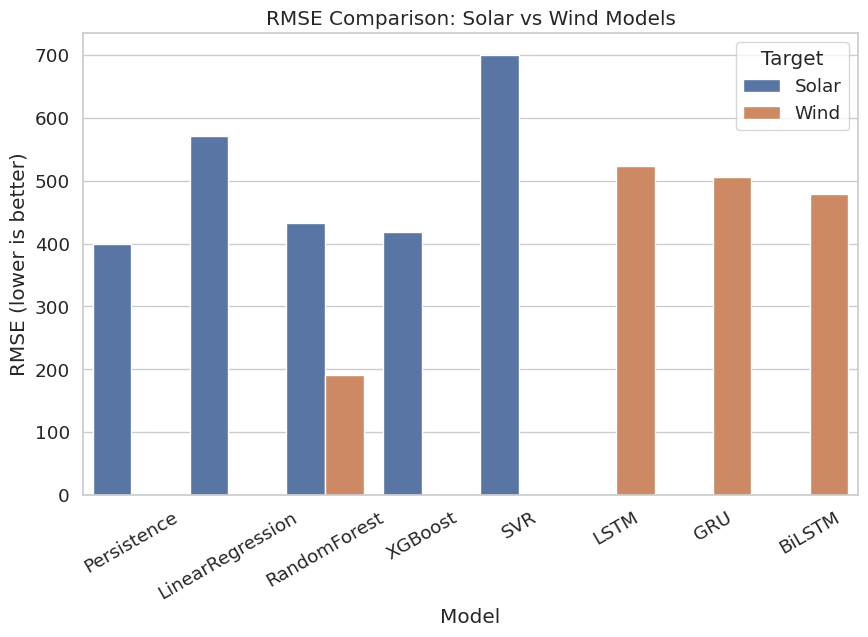

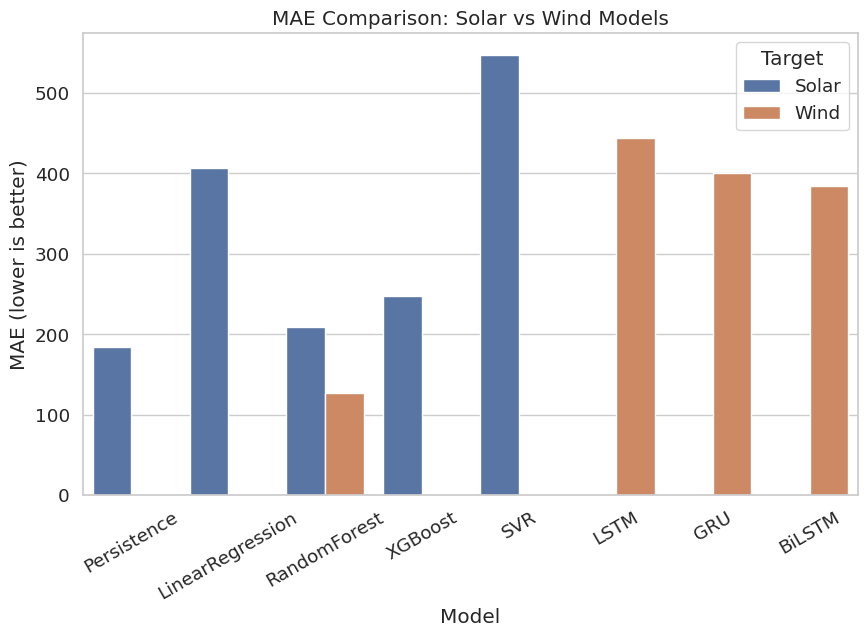

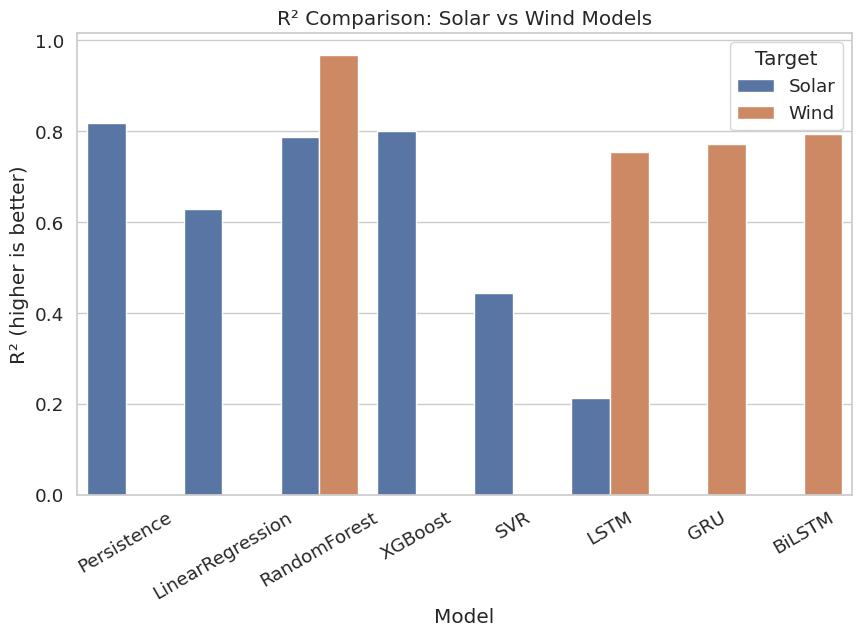

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot RMSE comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="RMSE",
    hue="Target"
)
plt.title("RMSE Comparison: Solar vs Wind Models")
plt.ylabel("RMSE (lower is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

# Plot MAE comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="MAE",
    hue="Target"
)
plt.title("MAE Comparison: Solar vs Wind Models")
plt.ylabel("MAE (lower is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

# Plot R² comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="R2",
    hue="Target"
)
plt.title("R² Comparison: Solar vs Wind Models")
plt.ylabel("R² (higher is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

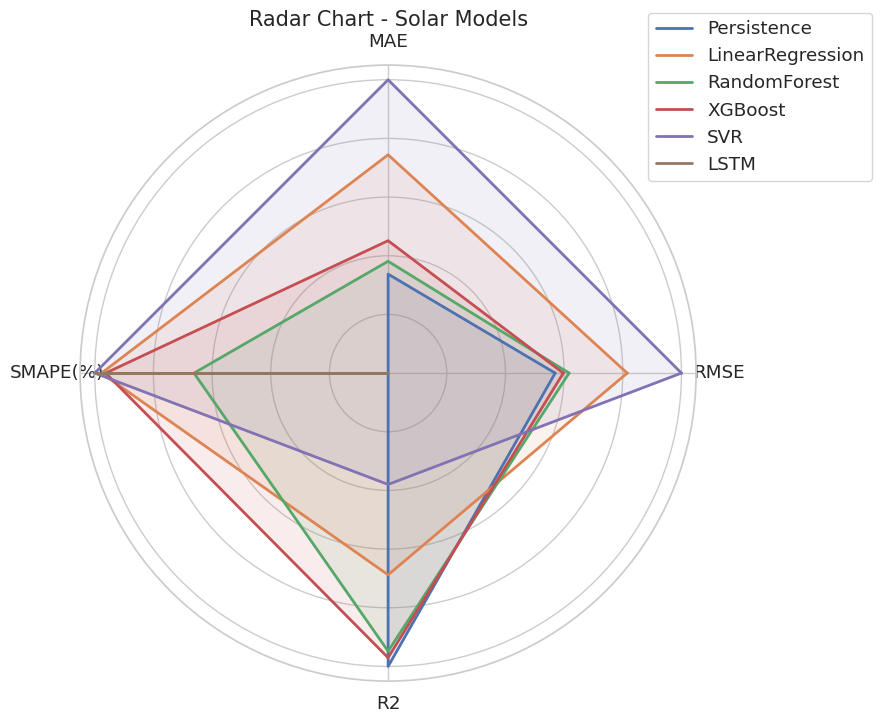

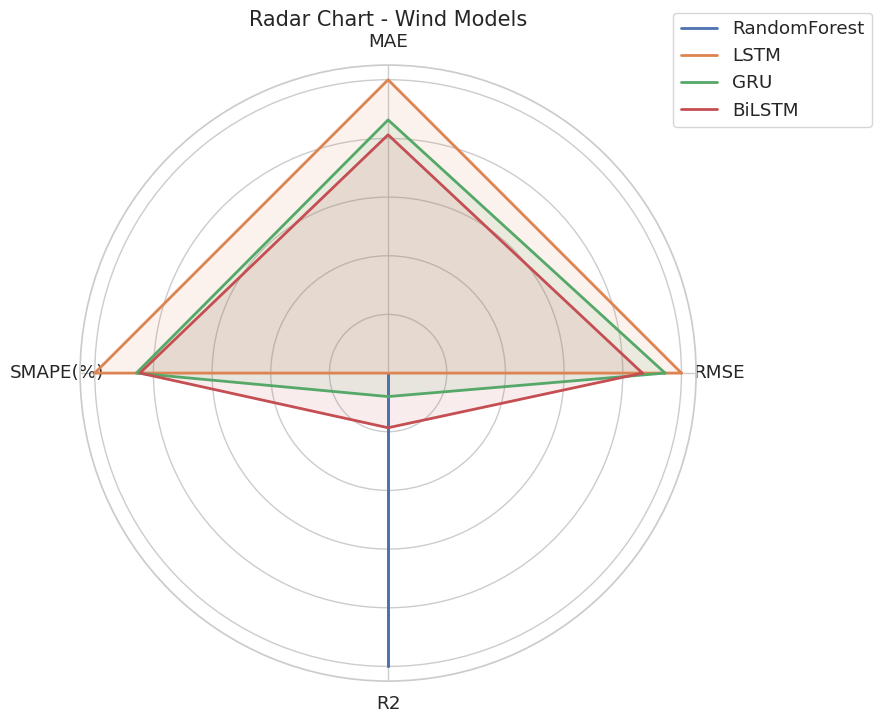

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize metrics so they fit on same radar scale
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-8)

# Select metrics
metrics = ["RMSE", "MAE", "SMAPE(%)", "R2"]

# Prepare radar data
radar_data = final_results.copy()
radar_data[metrics] = radar_data.groupby("Target")[metrics].transform(normalize)

# Radar plot function
def plot_radar(df, target, title):
    labels = metrics
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete loop

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    for _, row in df[df["Target"]==target].iterrows():
        values = row[labels].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row["Model"], linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    plt.title(title, size=15, y=1.05)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Plot radar charts for Solar and Wind separately
plot_radar(radar_data, target="Solar", title="Radar Chart - Solar Models")
plot_radar(radar_data, target="Wind", title="Radar Chart - Wind Models")